In [1]:
import math, random
import gym
import numpy as np
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.append('../')
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

<h3> Set configuration </h3>

In [4]:
from common.config import *
cfg = Config()

<h1>Atari Environment</h1>

In [5]:
from common.entropy import *

In [9]:
env_id = "DemonAttackNoFrameskip-v0"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

<h3>Use Cuda</h3>

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [11]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

## Replay Buffer

In [12]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [13]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<h2> Noisy Networks for Exploration</h2>

In [14]:
class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.in_features  = in_features
        self.out_features = out_features
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.FloatTensor(out_features, in_features))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(out_features))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(out_features))
        self.register_buffer('bias_epsilon', torch.FloatTensor(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(Variable(self.weight_epsilon))
            bias   = self.bias_mu   + self.bias_sigma.mul(Variable(self.bias_epsilon))
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.out_features))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x
    
    

<h2> Noisy Deep Q Network </h2>

In [15]:
class NoisyCnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(NoisyCnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.noisy1 = NoisyLinear(self.feature_size(), 512)
        self.noisy2 = NoisyLinear(512, env.action_space.n)
        
    def forward(self, x):
        x = x / 255.
        batch_size = x.size(0)
        
        x = self.features(x)
        x = x.view(batch_size, -1)
        
        x = F.relu(self.noisy1(x))
        x = self.noisy2(x)
        return x
    
    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()
        
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state):
        state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        action  = q_value.max(1)[1].data[0]
        return action
    
    def predict(self, state):
        state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        return q_value 
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 and classname.find('Layer') == -1:
            nn.init.xavier_normal(m.weight)
        
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

In [16]:
current_model = NoisyCnnDQN(env.observation_space.shape, env.action_space.n)
target_model = NoisyCnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model = target_model.cuda()
    
#optimizer = optim.RMSprop(current_model.parameters(), lr=cfg.LEARNING_RATE)
optimizer = optim.RMSprop(current_model.parameters(), lr=0.0001)

replay_initial = 32
replay_buffer = ReplayBuffer(cfg.REPLAY_BUFFER)

### Synchronize current net and target net

In [17]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

update_target(current_model, target_model)

<h2>Computing Temporal Difference Loss</h2>

In [18]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

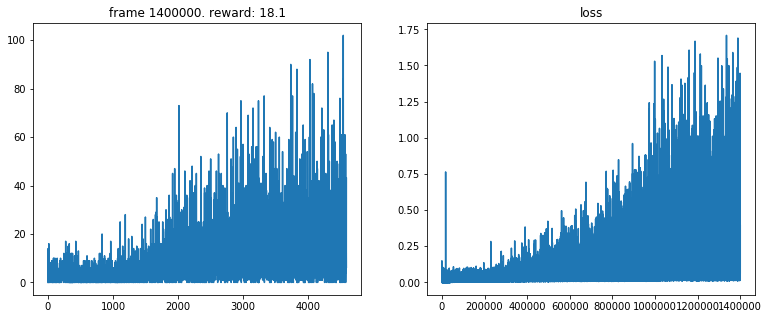

frame_idx: 1400000, (100.00 %), a:  2, r:   0, d: False, len_r: 4587

In [19]:
num_frames = cfg.NUM_FRAMES
batch_size = cfg.BATCH_SIZE
gamma      = cfg.GAMMA
episode = 0

losses = []
all_rewards = []
episode_reward = 0

state_traj = []
q_value_traj = []

episode_state = []
episode_q_val = []

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    action = current_model.act(state)
    
    if episode % 20 == 0:
        q_values = current_model.predict(state).data.cpu().numpy()[0]
        episode_state.append(state)
        episode_q_val.append(q_values)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
   
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        if episode % 20 == 0:
            state_traj.append(episode_state)
            q_value_traj.append(episode_q_val)
        
        episode += 1
        episode_state = []
        episode_q_val = []
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        update_target(current_model, target_model)
    
    print('\rframe_idx: %7d, (%.2f %%), a: %2d, r: %3d, d: %5s, len_r: %3d' %(frame_idx, frame_idx/num_frames*100, action, reward, done, len(all_rewards)), end='')

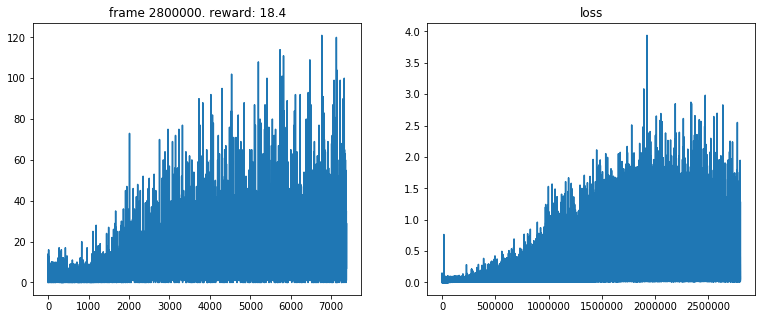

frame_idx: 2800000, (200.00 %), a:  4, r:   0, d: False, len_r: 7381

In [20]:
for frame_idx in range(1400001, num_frames + 1400001):
    action = current_model.act(state)
    if episode % 20 == 0:
        q_values = current_model.predict(state).data.cpu().numpy()[0]
        episode_state.append(state)
        episode_q_val.append(q_values)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
   
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        if episode % 20 == 0:
            state_traj.append(episode_state)
            q_value_traj.append(episode_q_val)
        
        episode += 1
        episode_state = []
        episode_q_val = []
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size)
        losses.append(loss.data[0])
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        update_target(current_model, target_model)
    
    print('\rframe_idx: %7d, (%.2f %%), a: %2d, r: %3d, d: %5s, len_r: %3d' %(frame_idx, frame_idx/num_frames*100, action, reward, done, len(all_rewards)), end='')

In [21]:
from common.save_file import *

model_dir = cfg.MODEL_DIR
var_dir = cfg.VAR_DIR
name = "noisy_" + env_id

save_model(current_model, model_dir, name)

var_dict = {
            "all_rewards": all_rewards,
            "losses": losses,
            "state_traj": state_traj,
            "q_value_traj": q_value_traj
           }

save_variable(name, var_dir, var_dict)

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type NoisyCnnDQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type NoisyLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model = torch.load('model/nosiy_Pong-v0.model')
state = env.reset()
done = False
for i in range(10):
    state = env.reset()
    done = False
    while not done:
        env.render()
        action = model.act(state)
        #action = env.action_space.sample()
        state, reward, done, info = env.step(action)
    env.close()

In [17]:
env.close()